## Comparing [SPCI](https://arxiv.org/abs/2212.03463) with EnbPI - Household Power Consumption Dataset

EnbPI
* Conference version: [ICML 2021](https://proceedings.mlr.press/v139/xu21h.html)
* Extended journal version: [IEEE TPAMI](https://ieeexplore.ieee.org/abstract/document/10121511)

**Dataset**: Individual Household Electric Power Consumption from UCI Machine Learning Repository
* Target: Global Active Power (kilowatts)
* Features: Voltage, Global Intensity, Sub-metering 1/2/3, Global Reactive Power
* Frequency: Minute-level measurements (subsampled for computational efficiency)


In [1]:
# Uninstall everything related to the project to clear the conflict
%pip uninstall -y numpy scipy scikit-learn sklearn-quantile skranger statsmodels pandas


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Reinstall with a strict ban on NumPy 2.0
!pip install "numpy<2.0" pandas scikit-learn sklearn-quantile skranger matplotlib scipy


  Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.3.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (91 kB)
  Using cached scikit_learn-1.7.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached sklearn_quantile-0.1.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.8 kB)
  Using cached skranger-0.8.0-cp310-cp310-macosx_10_15_x86_64.whl.metadata (8.1 kB)
  Using cached scipy-1.15.3-cp310-cp310-macosx_14_0_x86_64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of sklearn-quantile to determine which version is compatible with other requirements. This could take a while.
  Using cached sklearn_quantile-0.1.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.7 kB)
  Using cached sklearn_quantile-0.0.32-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.7 kB)
Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)
Using cached pandas-2.3.3-cp310-cp310-macosx_10_9_x86_64.whl (11.6 MB)
   ━━━━━━━━━━━━━━━━━━

In [3]:
# Correct spelling: statsmodels
%pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Data loader function for Household Power Consumption
import pandas as pd
import numpy as np

def load_household_power_dataset():
    """
    Loads Household Power Consumption dataset.
    Returns: X (features), Y (target) as numpy arrays.
    """
    # Load with semicolon separator
    df = pd.read_csv('Data/household_power_consumption.txt', sep=';', 
                     low_memory=False, na_values=['?'])
    
    # Drop rows with missing values
    df = df.dropna()
    
    # Subsample to every 15th row (every 15 minutes instead of every minute)
    # This reduces computational load while preserving patterns
    df = df.iloc[::15].reset_index(drop=True)
    
    # Further subsample: take last 10,000 points for computational efficiency
    df = df.iloc[-10000:].reset_index(drop=True)
    
    # Target: Global_active_power
    Y = df['Global_active_power'].values.astype(float)
    
    # Features: Drop Date, Time, and Target
    X_df = df.drop(columns=['Date', 'Time', 'Global_active_power'])
    X = X_df.values.astype(float)
    
    print(f"Loaded {len(Y)} samples with {X.shape[1]} features")
    print(f"Feature names: {X_df.columns.tolist()}")
    
    return X, Y


### To use [EnbPI](https://arxiv.org/abs/2010.09107), which is fast

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For EnbPI, larger `past_window` will make intervals wider.


In [5]:
# Define or get data
import torch

# Load household power consumption data
X_numpy, Y_numpy = load_household_power_dataset()
X_full = torch.from_numpy(X_numpy).float()
Y_full = torch.from_numpy(Y_numpy).float()

print('Full data shape')
print(X_full.shape, Y_full.shape)

# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]

# Use past_window # past residuals to predict the next one. If there are not so many residuals, one can decrease it
past_window = 300 
print(f'We will thus construct {len(Y_predict)} prediction intervals during test time')


Loaded 10000 samples with 6 features
Feature names: ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Full data shape
torch.Size([10000, 6]) torch.Size([10000])
We will thus construct 2000 prediction intervals during test time


In [6]:
# Initialize the SPCI class
from sklearn.ensemble import RandomForestRegressor
import SPCI_class as SPCI

fit_func = RandomForestRegressor(n_estimators=10, max_depth=2, criterion='squared_error',
                                bootstrap=False, n_jobs=-1, random_state=1103)
EnbPI_class_  = SPCI.SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
EnbPI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval


1/1 multi-step: finish Fitting 25 Bootstrap models, took 0.8825490474700928 secs.


In [7]:
use_SPCI = False
smallT = not use_SPCI
EnbPI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=False, stride=stride)
results = EnbPI_class_.get_results(alpha, 'household_power', 1)


Shape of slided residual lists is (2000, 300)
Finish Computing 2000 UNIQUE Prediction Intervals, took 1.6657750606536865 secs.
Average Coverage is 0.89
Average Width is 0.8801717847620778


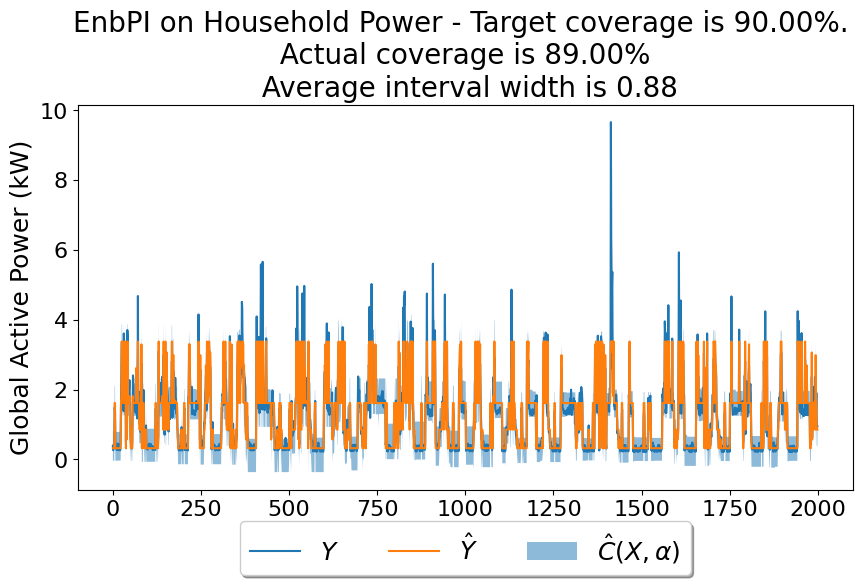

In [8]:
# Plot prediction intervals on test sample
Pred_ints = EnbPI_class_.PIs_Ensemble
Y_est = EnbPI_class_.Ensemble_pred_interval_centers
Y_predict = EnbPI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('Global Active Power (kW)')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'EnbPI on Household Power - Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')
plt.show()


### To use [SPCI](https://arxiv.org/abs/2212.03463), which performs better (i.e., intervals are narrower) but slower

In general, just pass in `X_full, Y_full` which are torch.tensor and specify what are the training samples and test samples by changing `train_frac`. Also, adjust `past_window` to specify the amount of past residuals to use when constructing intervals. 

For SPCI, larger `past_window` may or may not be better, depending on if there are "shifts" in the data distribution.


In [9]:
# Define or get data
import torch

# Load household power consumption data
X_numpy, Y_numpy = load_household_power_dataset()
X_full = torch.from_numpy(X_numpy).float()
Y_full = torch.from_numpy(Y_numpy).float()

print('Full data shape')
print(X_full.shape, Y_full.shape)

# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]

# Use past_window # past residuals to predict the next one. If there are not so many residuals, one can decrease it
past_window = 300 
print(f'We will thus construct {len(Y_predict)} prediction intervals during test time')


Loaded 10000 samples with 6 features
Feature names: ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Full data shape
torch.Size([10000, 6]) torch.Size([10000])
We will thus construct 2000 prediction intervals during test time


In [10]:
# Initialize the SPCI class
from sklearn.ensemble import RandomForestRegressor
import SPCI_class as SPCI

fit_func = RandomForestRegressor(n_estimators=10, max_depth=2, criterion='squared_error',
                                bootstrap=False, n_jobs=-1, random_state=1103)
SPCI_class_  = SPCI.SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
SPCI_class_.fit_bootstrap_models_online_multistep(
            B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval


1/1 multi-step: finish Fitting 25 Bootstrap models, took 1.2539846897125244 secs.


In [ ]:
use_SPCI = True
smallT = not use_SPCI
SPCI_class_.compute_PIs_Ensemble_online(
    alpha, smallT=smallT, past_window=past_window, use_SPCI=use_SPCI,
    quantile_regr=True, stride=stride)
results = SPCI_class_.get_results(alpha, 'household_power', 1)


Shape of slided residual lists is (2000, 8000)
Width at test 0 is 1.6984313130378723
Width at test 100 is 0.7221076786518097
Width at test 200 is 0.7446971237659454
Width at test 300 is 0.7331648766994476
Width at test 400 is 0.7482969164848328
Width at test 500 is 0.8711336255073547
Width at test 600 is 0.8030332028865814


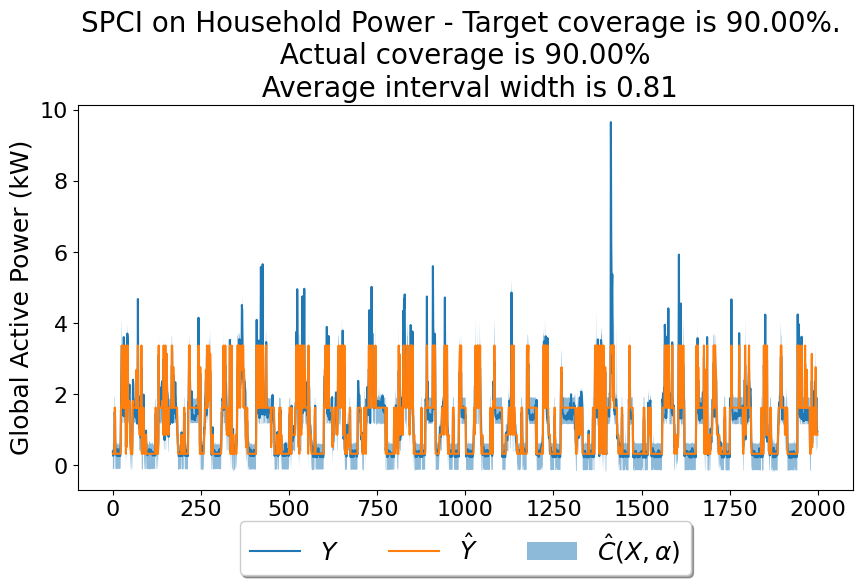

In [ ]:
# Plot prediction intervals on test sample
Pred_ints = SPCI_class_.PIs_Ensemble
Y_est = SPCI_class_.Ensemble_pred_interval_centers
Y_predict = SPCI_class_.Y_predict.numpy()
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(Y_predict, label=r'$Y$')
plt.plot(Y_est, label=r'$\hat{Y}$')
plt.fill_between(np.arange(len(Y_predict)), Pred_ints['lower'], Pred_ints['upper'], alpha=0.5, label=r'$\hat{C}(X,\alpha)$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=3)
plt.xlabel('Test time index')
plt.ylabel('Global Active Power (kW)')
actual_cov = 100*results["coverage"].item()
actual_wid = results["width"].item()
plt.title(f'SPCI on Household Power - Target coverage is {100*(1-alpha):.2f}%. \n Actual coverage is {actual_cov:.2f}% \n Average interval width is {actual_wid:.2f}')
plt.show()
